# Assignment 3: Class Activation Map
In this assignment we will use the [Class Activation Mapping Technique](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) to demonstrate that object specific spatial information is available in pre-trained image classification networks.

## Introduction:
The final output convolution layers of a trained image classification network contain detailed semantic information about the input image. These feature maps, although low resolution (e.g. 7 x 7) also contain spatial information about the location of the primary object in the image. In the class activation mapping technique we wish to extract this spatial information pertaining to the identified class and overlay this activation on the input image as shown in the figure below.

![](https://github.com/tonyscan6003/etivities/blob/main/cam_img.JPG?raw=true)

* Try to understand the algorithm and plan out the steps required before starting to code.
* The Resnet 50 model has been imported and outputs the last convolution layer and the logits (output of classifier)
* You can display your final results on a 4 x 4 plot.
 * Skeleton code is provided along with a function to unormalise the dataloader images for display.
 * The activation map using a heat map color scheme can be overlaid on the images using matplotlib "alpha" which sets the transparancy of the image e.g. `plt.imshow(class_act_map,cmap=plt.cm.jet,alpha=0.4)`























## HouseKeeping
  Import Packages, set batch size and Size of Images input to network.

In [56]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, models
from torchvision import utils
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [57]:
!pip install torchinfo
!pip install torchmetrics

In [58]:
# Global Variables
HW_trg =224

## Import Dataset

 For this notebook we will use the pytorch [ImageNett dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html) which contains a sub-set of the ImageNet test dataset with only 10 examples per class. This will be sufficient to demonstrate the Class Activation Mapping algorithm.

The transform is setup without data augmentation and with the required normalisation for the ResNet50 model.

In [59]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imagenet_data = datasets.Imagenette('/INET',download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=1,
                                          shuffle=True)

Plot a test image from the dataset. The image must be unnormalised and output in the correct form [H,W,C] for display by plt.imshow using `<unnormalise image function>`. (You can re-use this function later to unnormalise images that you will overlay the class activation maps onto.)

In [60]:

imagenette_dict={0:'Tench Fish',217:'English Springer',482:'Casette Player',
                491:'Chain Saw',497:'Church',566:'French Horn',
                 569:'Grabage Truck',571:'Gas Pump',574:'Golfball',
                 662:'Modem', 701:'Parachute',864:'Tow Truck', 867:'Trailer Truck'}
mean = [0.485, 0.456, 0.406]  # Example mean used for normalization
std = [0.229, 0.224, 0.225]   # Example std used for normalization

def unnormalize_image(image, mean, std):
    """
    Unnormalize a PyTorch image tensor.

    Args:
        image (torch.Tensor): The normalized image tensor of shape [C, H, W].
        mean (list or tuple): The mean used for normalization.
        std (list or tuple): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The unnormalized image tensor.
    """
    # Remove the batch dimension
    image = image.squeeze(0)

    # Check if the image is in the shape [C, H, W]
    if image.dim() == 3:
        # Unnormalize the image
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
    else:
        raise ValueError("Expected image tensor of shape [C, H, W]")

    # Convert from [C, x, y] to [x, y, C]
    image = image.permute(1, 2, 0)

    return image

torch.Size([1, 3, 224, 224])


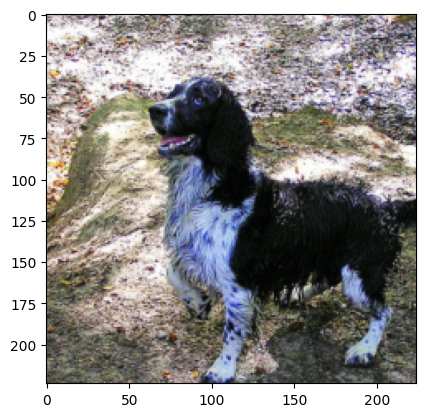

In [61]:
# Verity Dataloader & Image
dataiter = iter(data_loader)
z = next(dataiter)
print(np.shape(z[0]))

img=unnormalize_image(z[0],mean,std)
plt.imshow(img)




# Import Model

This assignment can be completed with CPU runtime as only inference from the model is required. The ResNet50 model is imported for this Assignment. As detailed in the paper a global average pooling layer conected to the classifier layer is required to work. The Resnet50 model satisfies this requirement (without needing modification & retraining)

In [62]:
# Get cpu, gpu or mps device for training.
#device = (
#    "cuda"
#    if torch.cuda.is_available()
#    else "mps"
#    if torch.backends.mps.is_available()
#    else "cpu"
#)

device = "cpu"

print(f"Using {device} device")

Using cpu device


ResNet50 Model is loaded & modified with [create_feature_extraction](https://pytorch.org/vision/stable/feature_extraction.html) to allow output of both logits and feature maps

In [63]:
# Load Model with weights
resnet50 = models.resnet50(pretrained=True)

# Obtain list of graph nodes
train_nodes, eval_nodes = get_graph_node_names(resnet50)
#print(train_nodes)

# Define Dictionary of output nodes
return_nodes={'layer4.2.conv3':'op_features','fc':'op_logits'}

# Create new model using the return nodes
model=create_feature_extractor(resnet50, return_nodes=return_nodes)

c:\Users\cianm\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cianm\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Module(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [65]:
# Plot Model Summary
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Module: 1-5                            --                        --
│    └─Module: 2-1                       --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

Test Passing data through model & verify outputs.

In [66]:
#pass data through model
out=model(z[0])
print([(k, v.shape) for k, v in out.items()])


[('op_features', torch.Size([1, 2048, 7, 7])), ('op_logits', torch.Size([1, 1000]))]


Obtain weights of classifier layer of model from state dictionary

In [67]:
sd = model.state_dict()
print(sd.keys())
print(np.shape((sd['fc.weight'])))

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

# Class Activion Mapping
You can implement the class activation mapping algorithm in the code cell below.



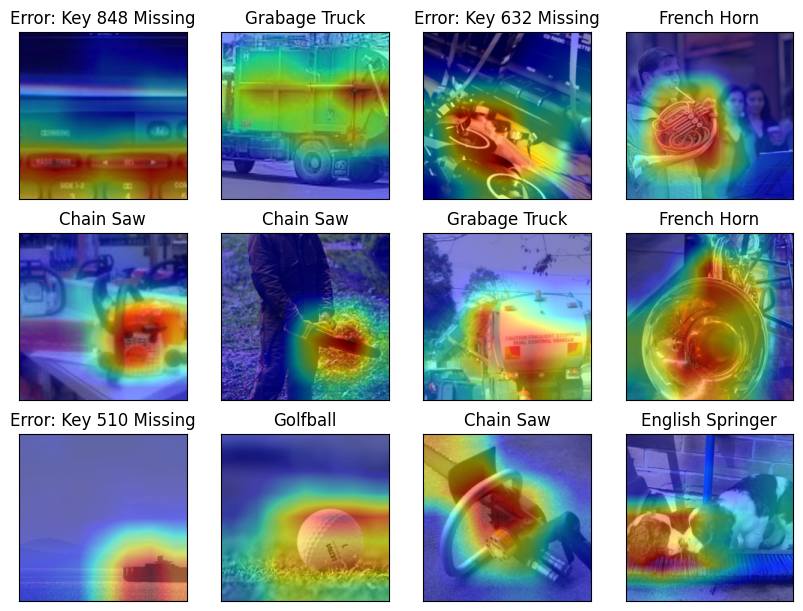

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Get FC weights from the state dictionary
sd = model.state_dict()
fc_weights = sd['fc.weight']

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()

# Iterate over the dataiter to produce a few examples
for i in range(12):

    ######################################################
    # Your Code here #####################################
    ######################################################

    # Get the image and target from the dataloader
    data = next(dataiter)
    img, curr_class = data[0].to(device), data[1].to(device)
    
    img_tensor = img[0].unsqueeze(0) 

    # 1. Forward Pass
    out = model(img_tensor)

    # extract feature map and logits 
    feature_map = out['op_features']
    logits = out['op_logits']    

    # 2. Identify Target Class
    # Get the index of the predicted class (the class with the highest logit value)
    _, pred_class_idx = torch.max(logits, 1)
    
    # Convert to scalar for indexing
    pred_class_idx = pred_class_idx.item()

    # 3. & 4. Extract and Squeeze Weights
    # Get the weights for the predicted class from the FC layer weights
    class_weights = fc_weights[pred_class_idx]
    
    # Reshape weights for element-wise multiplication
    # The shape needs to be (1, C, 1, 1) to align correctly with (1, C, H, W)
    class_weights = class_weights.view(1, -1, 1, 1)

    # 5. Compute CAM
    # Weighted sum: multiply each channel by its corresponding weight and sum across channels.
    cam = torch.sum(feature_map * class_weights, dim=1, keepdim=False) 
    
    # 6. Upsample and Normalize
    # Upsample the CAM to the original image size (e.g., 224x224)
    H, W = img_tensor.shape[-2], img_tensor.shape[-1]
    
    # Use bilinear interpolation to upsample
    act_map_us = F.interpolate(
        cam.unsqueeze(0), 
        size=(H, W), 
        mode='bilinear', 
        align_corners=False
    ).squeeze(0).squeeze(0) # Remove batch and channel dims

    # Normalize the final CAM for visualization
    # ReLU to keep only positive activations
    act_map_us = torch.relu(act_map_us)
    
    # Min-max normalization: (X - min) / (max - min)
    # Check for division by zero
    act_map_max = act_map_us.max()
    if act_map_max > 0:
        act_map_us = act_map_us / act_map_max
    
    ######################################################
    # End of my Code ###################################
    ######################################################

    # N. Plotting
    img = img_tensor[0] # Select the image tensor (3, H, W)
    
    def get_value(dictionary, key):
        try:
            return dictionary[key]
        except KeyError:
        # Tells you exactly what key was missing
            return f"Error: Key {key} Missing"
    
    # Use the predicted class index for the title
    label = get_value(imagenette_dict, pred_class_idx) 

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    
    # Unnormalize the image for display
    img_display=unnormalize_image(img,mean,std) 
    
    # Display the unnormalized image
    ax.imshow(img_display)
    
    # Overlay the normalized and upsampled activation map with transparency
    ax.imshow(act_map_us.cpu().detach().numpy(), cmap=plt.cm.jet, alpha=0.5)

plt.show()

# You may Leave a note here explaining your approach/results for the e-moderator.

Please clearly identify any code blocks you have used, suggestions your have tried or ideas obtained from other students. This information may also be posted as a final reflection post in the forum.

# Steps followed:

## 1 - Model Preparation
- Load the FC Weights from the model state dictionary to be used when representing the importance of each feature class
- Model set to evaluation mode to disable training modification as this is only inference

## 2 - The Forward Pass
- Image data is loaded to the model and moved to the CPU. Batch Normalisation added to the tensor input
- Pass the prepared images into the trained ResNet50 Model.

## 3 - Capture the outputs from the forward pass
- As the resNet50 model was modified to output the Feature Map from the last convolution layer and the Logits these are extracted using the dictionary keys set in the skeleton code earlier.

## 4 - Computing the Class Activation Map
- Determin the models predicted class by finding the largest Logit value for the image
- Use the identified index of the Max logit to find the corresponding weights from "fc_weights"
- Class Activvation map is a weighted sum of the feature map channels as per below:

$$CAM=\sum{W_k^c \times A_k}$$

## 5 - Post Processing
- Implementation of Bilinear interpolation to increase the size of the CAM to match the size of the input image
- Applying a ReLU operation to ensure only features with values above 0 contribute to the plot
- Normalise the scale of the CAM values between 0-1 for heatmap plotting purposes
- Apply the CAM as a heatmap overlay of the original image

#### Note: There appears to be some noisy images within the dataset, from referenceing the imagenette dataset this is intential for training purposes, as such the unknown id will be displayed to prevent the plotting from erroring